In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/yufung/ab-testing-cookie-cats/master/data/cookie_cats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [5]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

<Axes: >

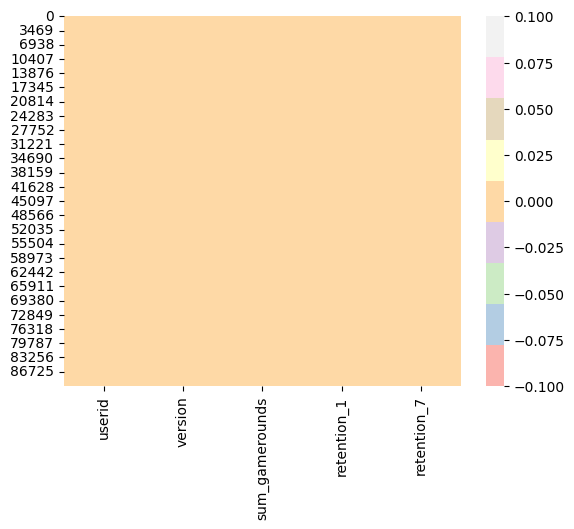

In [6]:
sns.heatmap( df.isnull(), 
            cmap='Pastel1',
            cbar=True )

## Distribution of 2 groups

In [7]:
df.groupby('version')['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


''

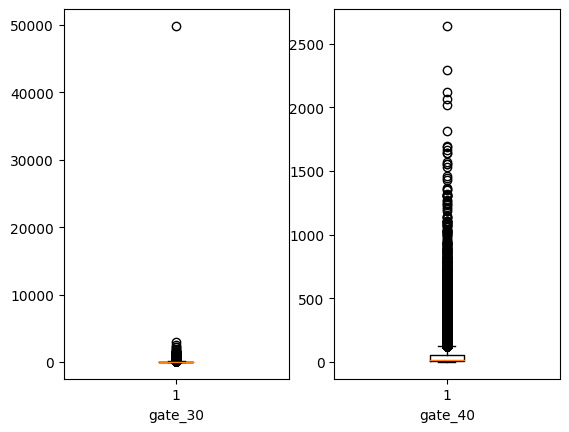

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].boxplot(df[df['version']=='gate_30']['sum_gamerounds'])
ax[1].boxplot(df[df['version']=='gate_40']['sum_gamerounds']) 
ax[0].set_xlabel('gate_30')
ax[1].set_xlabel('gate_40')
;

In [9]:
df[df['version']=='gate_30'].sort_values(['sum_gamerounds'], ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
43671,4832608,gate_30,2438,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True


In [10]:
# remove outlier

ab = df[ df['sum_gamerounds'] < df['sum_gamerounds'].max() ]
ab.sort_values('sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True


In [11]:
#after remove outlier

ab.groupby(['version'])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


''

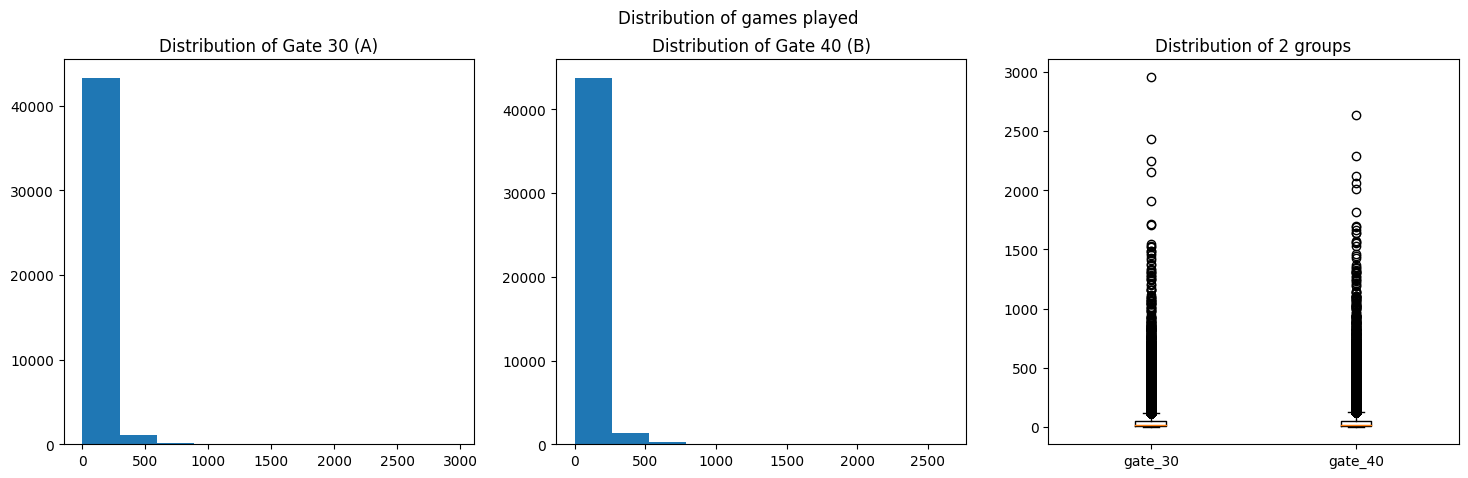

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax[0].hist( ab[ab['version']=='gate_30']['sum_gamerounds'] )
ax[1].hist( ab[ab['version']=='gate_40']['sum_gamerounds'] )
ax[2].boxplot([ ab.loc[ab['version']=='gate_30','sum_gamerounds'], 
                ab.loc[ab['version']=='gate_40','sum_gamerounds'] 
             ])

fig.suptitle('Distribution of games played')
ax[0].set_title('Distribution of Gate 30 (A)')
ax[1].set_title('Distribution of Gate 40 (B)')
ax[2].set(title='Distribution of 2 groups',
          xticklabels = ab['version'].unique()
          )
;

## During first 14 days, how many games have users played?

In [13]:
ab.groupby('sum_gamerounds').count().reset_index()[['sum_gamerounds', 'userid']]

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
936,2251,1
937,2294,1
938,2438,1
939,2640,1


''

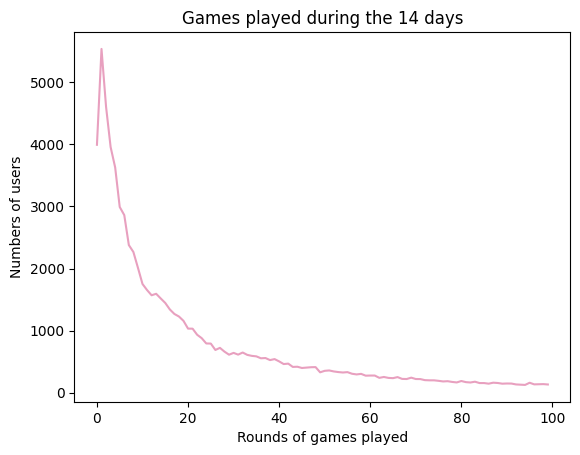

In [14]:
plt.plot(ab.groupby('sum_gamerounds').count().reset_index()['sum_gamerounds'].head(100),
        ab.groupby('sum_gamerounds').count().reset_index()['userid'].head(100),
        color = '#'+'E8A0BF'
        )
plt.title('Games played during the 14 days')
plt.xlabel('Rounds of games played')
plt.ylabel('Numbers of users')
;

## Retention 

In [15]:
# Retention rate for each version
ab.groupby(['version'])[['retention_1','retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


In [16]:
# Retention and Churn rate 
pd.DataFrame({
    'Retention_1' : ab['retention_1'].mean() ,
    'Churn_1' : 1 - ab['retention_1'].mean() ,
    'Retention_7' : ab['retention_7'].mean() ,
    'Churn_7' : 1 - ab['retention_7'].mean()
}, index=[0])


,Retention_1,Churn_1,Retention_7,Churn_7
0,0.445214,0.554786,0.186056,0.813944


In [17]:
# How many players reach round 30 & 40
ab.groupby(['sum_gamerounds'])['userid'].count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

## A/B Testing

In [18]:
ab['Rention1_Retention7'] = list(map(lambda x,y : str(x)+"-"+str(y), ab['retention_1'], ab['retention_7']))
ab.head()

C:\Users\Dinh Khoi\AppData\Local\Temp\ipykernel_18052\2688950057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab['Rention1_Retention7'] = list(map(lambda x,y : str(x)+"-"+str(y), ab['retention_1'], ab['retention_7']))


,userid,version,sum_gamerounds,retention_1,retention_7,Rention1_Retention7
0,116,gate_30,3,False,False,False-False
1,337,gate_30,38,True,False,True-False
2,377,gate_40,165,True,False,True-False
3,483,gate_40,1,False,False,False-False
4,488,gate_40,179,True,True,True-True


### 1. Check normality

In [19]:
import scipy.stats as stats
#from scipy.stats import shapiro #test for normality
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, \
    kendalltau, f_oneway, kruskal


In [20]:
groupA = ab[ab['version']=='gate_30']['sum_gamerounds']
groupB = ab[ab['version']=='gate_40']['sum_gamerounds']

In [21]:
groupA.info()

<class 'pandas.core.series.Series'>
Int64Index: 44699 entries, 0 to 90186
Series name: sum_gamerounds
Non-Null Count  Dtype
--------------  -----
44699 non-null  int64
dtypes: int64(1)
memory usage: 698.4 KB


In [22]:
groupB.info()

<class 'pandas.core.series.Series'>
Int64Index: 45489 entries, 2 to 90188
Series name: sum_gamerounds
Non-Null Count  Dtype
--------------  -----
45489 non-null  int64
dtypes: int64(1)
memory usage: 710.8 KB


In [27]:
testStatsA, pValueA = shapiro(groupA)
print(print("Test Stat = %.4f, p-value = %.4f" % (testStatsA, pValueA)))

testStatsB, pValueB = shapiro(groupB)
print(print("Test Stat = %.4f, p-value = %.4f" % (testStatsB, pValueB)))

Test Stat = 0.4886, p-value = 0.0000
None
Test Stat = 0.4826, p-value = 0.0000
None


c:\Users\Dinh Khoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+ H0: Normal distribution assumption is true.
+ H1: False.

+ If p-value < 0.05, H0 = Reject
+ If p-value > 0.05 H0 = Cannot Reject.

====

Per result,
+ p-value (gate-30) < 0.05 => Reject H0 => The data is not normally distributed
+ p-value (gate-40) < 0.05 => Reject H0 => The data is not normally distributed

### 2. Variance Homogeneity Assumption

In [29]:
testStats, pValue = levene(groupA, groupB)
print(print("Test Stat = %.4f, p-value = %.4f" % (testStats, pValue)))

Test Stat = 0.0751, p-value = 0.7840
None


+ H0: Variance is homogeneous.
+ H1: Variance is not homogeneous.

+ If p-value < 0.05, H0 = Reject
+ If p-value > 0.05 H0 = Cannot Reject.

====
+ p-value > 0.05 => Cannot reject H0 => Variance is not homogeneous

### 3. Apply of the Hypothesis

In [30]:
testStats, pValue = mannwhitneyu(groupA, groupB)
print(print("Test Stat = %.4f, p-value = %.4f" % (testStats, pValue)))

Test Stat = 1024285761.5000, p-value = 0.0509
None


According to the result of A/B Testing, we calculated the p-value = 0.0509, which is larger than 0.05.
We cannot reject H0 hypothesis, which means the changes from gate_30 to gate_40 does not affect total game rounds played.